In [1]:
from __future__ import division, print_function
import os
import numpy as np 
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_validate
import time
random_state = 10

In [2]:
train_path = os.path.join(os.getcwd(), 'project','dataset', 'ticdata2000.csv')
X_test_path = os.path.join(os.getcwd(), 'project', 'dataset', 'ticeval2000.txt')
y_test_path = os.path.join(os.getcwd(), 'project', 'dataset', 'tictgts2000.txt')
landsat_train = pd.read_csv(train_path, delimiter = ',',header=0)
X_test = pd.read_csv(X_test_path, delimiter = ' ',header=None)
y_test = pd.read_csv(y_test_path, delimiter = ' ',header=None)

In [3]:
#未处理原始数据
or_train_path = os.path.join(os.getcwd(), 'project','dataset', 'ticdata2000_orig.csv')
label_path = os.path.join(os.getcwd(), 'project','dataset', 'labels.csv')
# val_path = os.path.join(os.getcwd(), 'project', 'dataset', 'ticeval2000.txt')
# test_path = os.path.join(os.getcwd(), 'project', 'dataset', 'tictgts2000.txt')
landsat_train_original = pd.read_csv(or_train_path, delimiter = ',',header=0)
landsat_labels_original = pd.read_csv(label_path, delimiter = ',',header=0)

print(landsat_labels_original.iloc[:,0].tolist())
# X_test = pd.read_csv(val_path, delimiter = ' ',header=None)
# y_test = pd.read_csv(test_path, delimiter = ' ',header=None)

['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK', 'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN', 'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG', 'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA', 'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2', 'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED', 'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND']


In [4]:
x =[]
y =[]
def draw_relation(feature):
    features = []
    policy = []
    dic = defaultdict(dict)
    for ii in range(landsat_train_original.shape[0]):
        if (landsat_train_original["CARAVAN"][ii] == 1):
            if (dic.get(landsat_train_original[feature][ii])):
                dic[landsat_train_original[feature][ii]] += 1 
            else :
                dic[landsat_train_original[feature][ii]] = 1
    for i in sorted (dic) : 
        features.append(i)
        policy.append(dic[i])
    print(dic)
    x.append(features)
    y.append(policy)


MOSTYPE
defaultdict(<class 'dict'>, {11: 9, 38: 23, 12: 16, 9: 12, 36: 16, 3: 25, 8: 51, 34: 9, 41: 5, 10: 9, 1: 13, 33: 46, 13: 13, 35: 8, 31: 6, 6: 12, 32: 8, 39: 19, 24: 5, 29: 2, 26: 1, 7: 3, 37: 10, 25: 2, 2: 6, 22: 4, 30: 4, 23: 4, 4: 2, 5: 2, 20: 2, 27: 1})


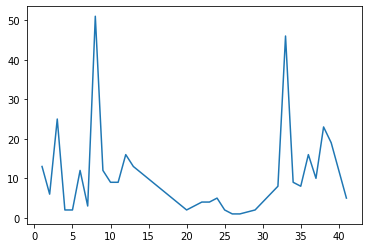

MAANTHUI
defaultdict(<class 'dict'>, {1: 315, 2: 33})


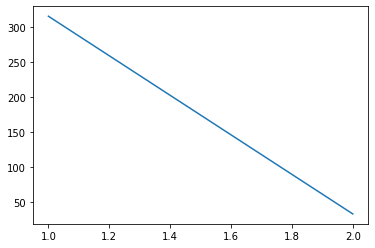

MGEMOMV
defaultdict(<class 'dict'>, {3: 171, 2: 115, 4: 50, 1: 8, 5: 4})


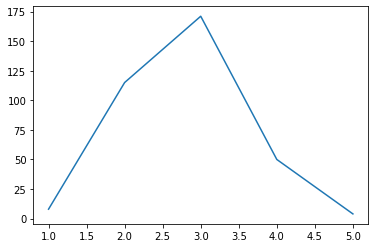

MGEMLEEF
defaultdict(<class 'dict'>, {3: 183, 2: 87, 4: 64, 5: 12, 1: 1, 6: 1})


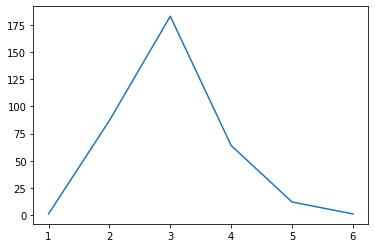

MOSHOOFD
defaultdict(<class 'dict'>, {3: 59, 9: 42, 8: 89, 1: 48, 2: 66, 10: 5, 7: 20, 5: 15, 6: 4})


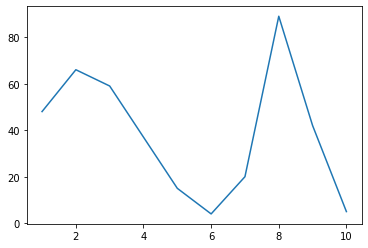

MGODRK
defaultdict(<class 'dict'>, {2: 54, 0: 177, 1: 107, 3: 7, 5: 1, 4: 1, 6: 1})


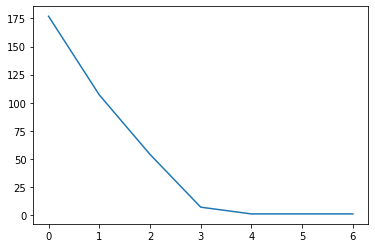

MGODPR
defaultdict(<class 'dict'>, {7: 55, 5: 97, 6: 39, 4: 87, 0: 1, 9: 8, 2: 24, 3: 29, 8: 3, 1: 5})


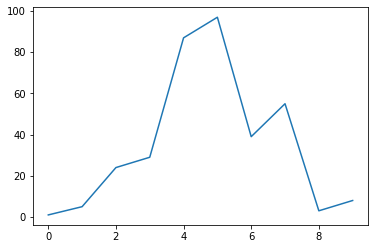

MGODOV
defaultdict(<class 'dict'>, {0: 130, 1: 93, 2: 99, 4: 7, 3: 18, 5: 1})


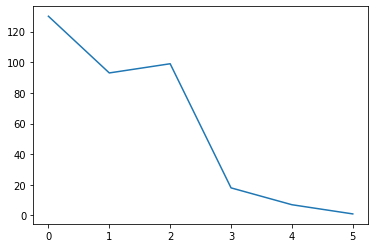

MGODGE
defaultdict(<class 'dict'>, {0: 37, 3: 87, 2: 69, 7: 9, 1: 21, 4: 70, 5: 51, 6: 4})


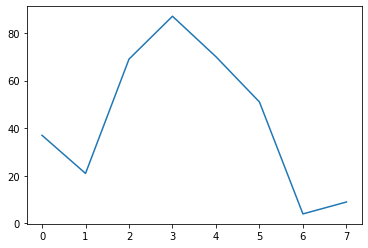

MRELGE
defaultdict(<class 'dict'>, {9: 66, 7: 116, 6: 71, 8: 25, 4: 10, 5: 48, 0: 2, 3: 6, 1: 1, 2: 3})


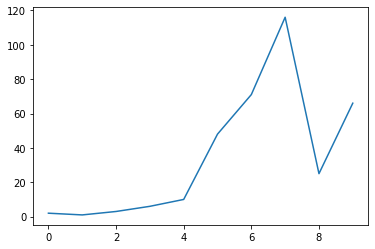

MRELSA
defaultdict(<class 'dict'>, {0: 161, 1: 120, 2: 59, 3: 7, 4: 1})


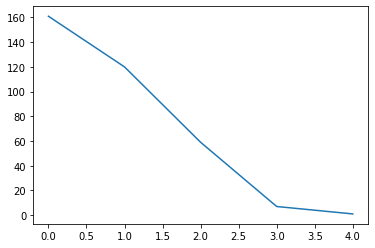

MRELOV
defaultdict(<class 'dict'>, {0: 93, 2: 110, 1: 33, 3: 74, 4: 26, 6: 4, 5: 6, 9: 1, 7: 1})


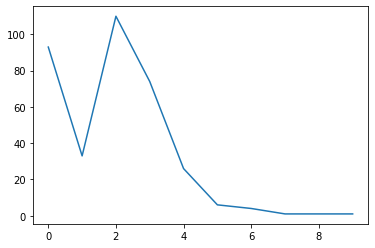

MFALLEEN
defaultdict(<class 'dict'>, {2: 75, 3: 41, 1: 64, 5: 13, 0: 128, 6: 4, 4: 21, 8: 1, 7: 1})


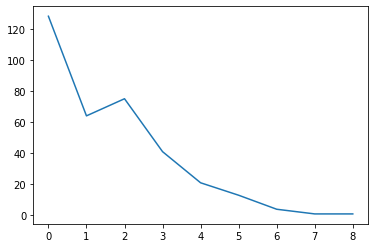

MFGEKIND
defaultdict(<class 'dict'>, {3: 89, 2: 57, 1: 24, 4: 88, 5: 30, 0: 23, 6: 27, 7: 8, 9: 1, 8: 1})


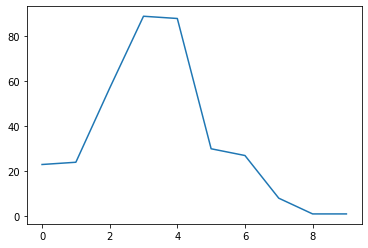

MFWEKIND
defaultdict(<class 'dict'>, {4: 66, 5: 58, 6: 56, 3: 59, 8: 18, 7: 23, 9: 14, 0: 5, 2: 39, 1: 10})


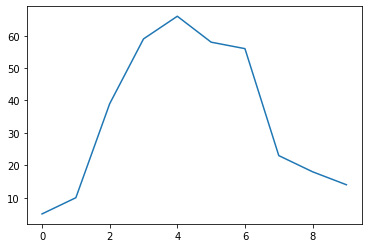

MOPLHOOG
defaultdict(<class 'dict'>, {0: 91, 1: 73, 2: 70, 5: 21, 7: 6, 3: 39, 4: 37, 8: 2, 6: 8, 9: 1})


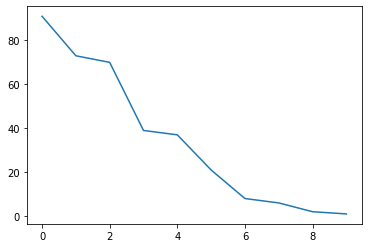

MOPLMIDD
defaultdict(<class 'dict'>, {5: 54, 3: 80, 4: 86, 2: 48, 0: 14, 1: 22, 6: 19, 8: 3, 7: 18, 9: 4})


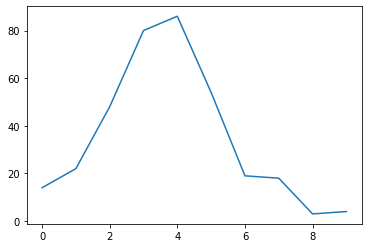

MOPLLAAG
defaultdict(<class 'dict'>, {4: 51, 6: 32, 0: 29, 3: 47, 1: 27, 5: 49, 9: 8, 2: 65, 7: 27, 8: 13})


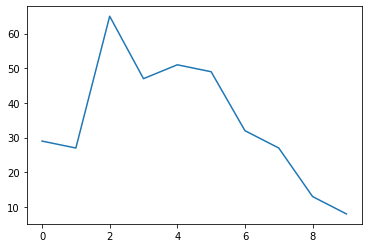

MBERHOOG
defaultdict(<class 'dict'>, {5: 13, 2: 78, 1: 61, 4: 33, 7: 14, 3: 53, 0: 73, 6: 18, 9: 2, 8: 3})


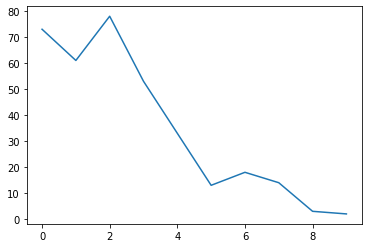

MBERZELF
defaultdict(<class 'dict'>, {0: 233, 1: 82, 2: 26, 5: 3, 3: 3, 4: 1})


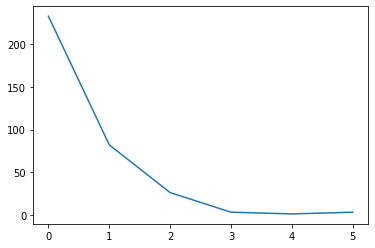

MBERBOER
defaultdict(<class 'dict'>, {0: 284, 1: 36, 3: 6, 2: 20, 4: 1, 5: 1})


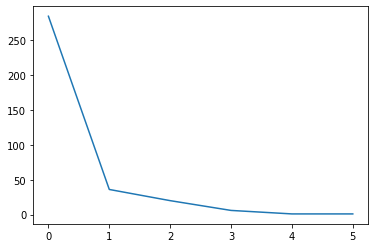

MBERMIDD
defaultdict(<class 'dict'>, {4: 61, 2: 85, 5: 33, 3: 68, 0: 35, 7: 22, 9: 8, 6: 17, 1: 19})


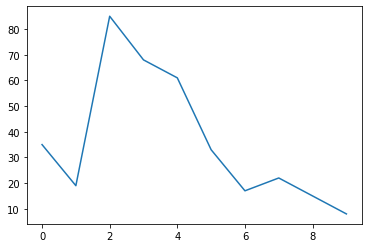

MBERARBG
defaultdict(<class 'dict'>, {0: 77, 3: 49, 2: 86, 1: 83, 7: 5, 5: 13, 4: 25, 6: 6, 8: 3, 9: 1})


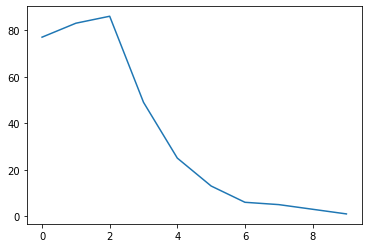

MBERARBO
defaultdict(<class 'dict'>, {1: 76, 3: 50, 0: 78, 4: 38, 2: 82, 5: 15, 6: 6, 7: 2, 8: 1})


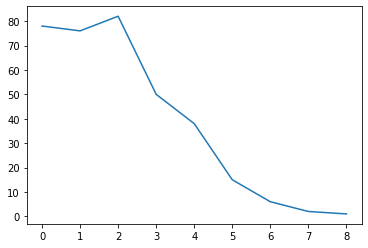

MSKA
defaultdict(<class 'dict'>, {1: 80, 0: 84, 7: 13, 4: 29, 3: 48, 2: 67, 5: 14, 6: 12, 8: 1})


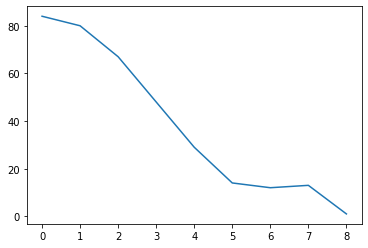

MSKB1
defaultdict(<class 'dict'>, {2: 101, 1: 81, 3: 65, 8: 1, 0: 72, 4: 19, 6: 5, 5: 4})


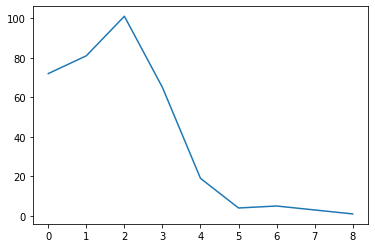

MSKB2
defaultdict(<class 'dict'>, {4: 47, 1: 47, 2: 100, 0: 58, 5: 17, 3: 73, 6: 6})


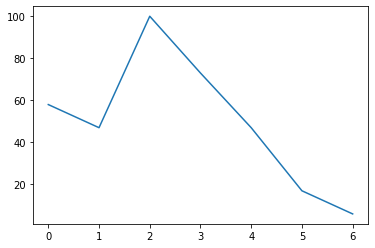

MSKC
defaultdict(<class 'dict'>, {2: 71, 5: 46, 4: 62, 0: 25, 9: 6, 1: 30, 3: 61, 8: 8, 6: 29, 7: 10})


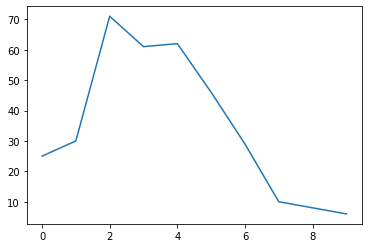

MSKD
defaultdict(<class 'dict'>, {2: 40, 0: 188, 1: 98, 3: 14, 4: 5, 6: 1, 7: 1, 5: 1})


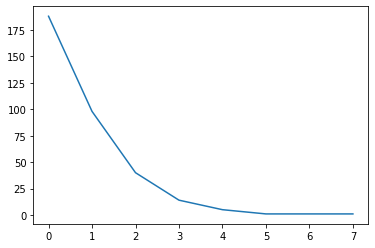

MHHUUR
defaultdict(<class 'dict'>, {1: 37, 5: 25, 0: 94, 9: 31, 2: 38, 4: 26, 6: 23, 3: 39, 7: 19, 8: 16})


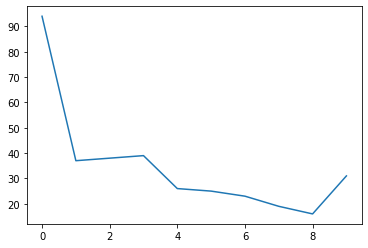

MHKOOP
defaultdict(<class 'dict'>, {8: 37, 4: 25, 9: 94, 0: 31, 7: 38, 5: 26, 3: 23, 6: 39, 2: 19, 1: 16})


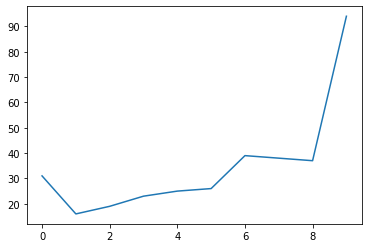

MAUT1
defaultdict(<class 'dict'>, {7: 119, 5: 59, 9: 39, 8: 19, 6: 91, 4: 13, 3: 7, 2: 1})


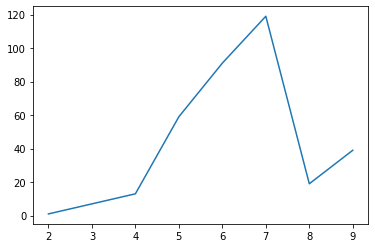

MAUT2
defaultdict(<class 'dict'>, {2: 112, 0: 107, 1: 84, 3: 22, 4: 19, 5: 3, 6: 1})


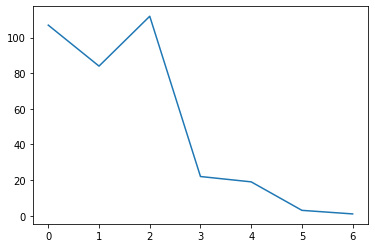

MAUT0
defaultdict(<class 'dict'>, {0: 121, 2: 108, 1: 48, 3: 49, 6: 5, 4: 13, 5: 4})


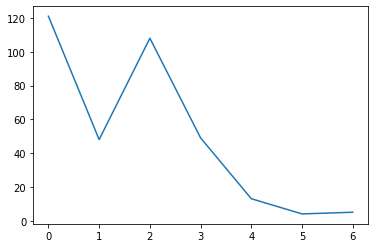

MZFONDS
defaultdict(<class 'dict'>, {7: 87, 5: 72, 4: 28, 3: 15, 6: 45, 9: 39, 8: 28, 2: 27, 0: 7})


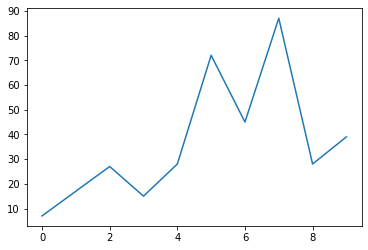

MZPART
defaultdict(<class 'dict'>, {2: 87, 4: 72, 5: 28, 6: 15, 3: 45, 0: 39, 1: 28, 7: 27, 9: 7})


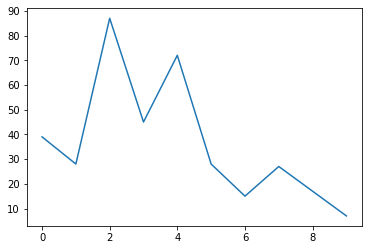

MINKM30
defaultdict(<class 'dict'>, {2: 91, 4: 21, 0: 98, 1: 54, 3: 50, 7: 7, 6: 9, 5: 17, 8: 1})


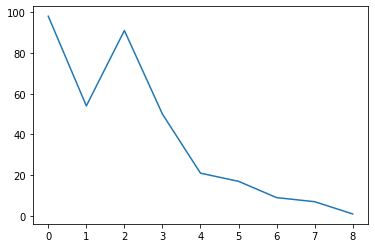

MINK3045
defaultdict(<class 'dict'>, {4: 84, 5: 45, 3: 74, 2: 55, 0: 26, 9: 9, 1: 18, 7: 10, 6: 25, 8: 2})


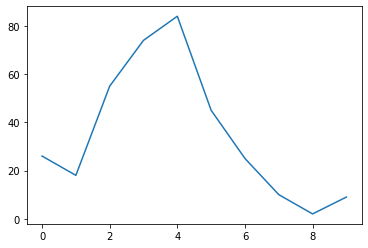

MINK4575
defaultdict(<class 'dict'>, {3: 84, 1: 24, 4: 88, 6: 11, 5: 41, 2: 48, 0: 38, 7: 7, 8: 3, 9: 4})


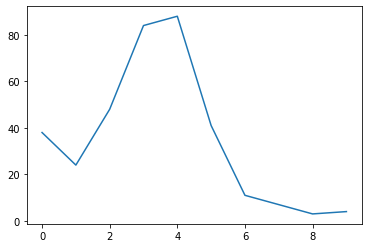

MINK7512
defaultdict(<class 'dict'>, {0: 152, 1: 97, 2: 58, 4: 14, 5: 7, 3: 19, 9: 1})


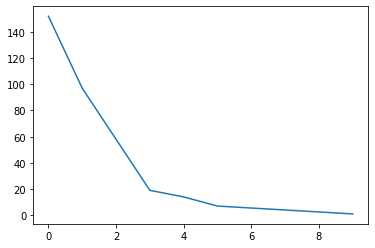

MINK123M
defaultdict(<class 'dict'>, {1: 50, 0: 289, 2: 8, 3: 1})


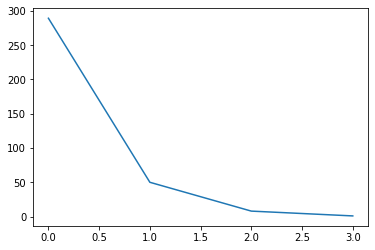

MINKGEM
defaultdict(<class 'dict'>, {4: 139, 3: 69, 5: 70, 7: 17, 6: 24, 2: 20, 8: 8, 1: 1})


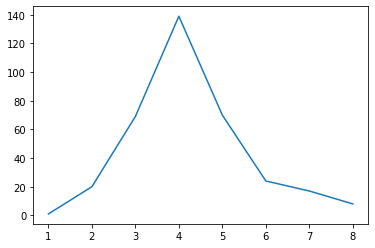

MKOOPKLA
defaultdict(<class 'dict'>, {6: 66, 4: 46, 7: 67, 3: 71, 5: 30, 8: 35, 1: 18, 2: 15})


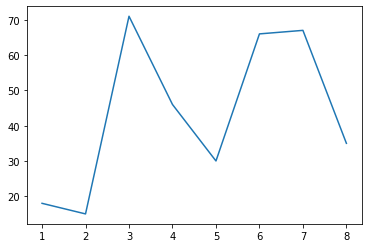

PWAPART
defaultdict(<class 'dict'>, {2: 191, 0: 147, 3: 2, 1: 8})


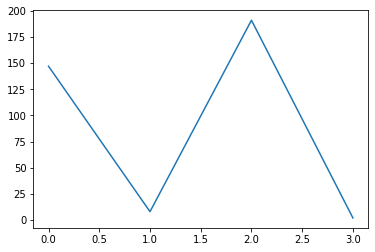

PWABEDR
defaultdict(<class 'dict'>, {0: 343, 3: 3, 2: 2})


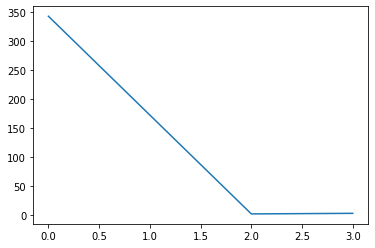

PWALAND
defaultdict(<class 'dict'>, {0: 345, 3: 2, 4: 1})


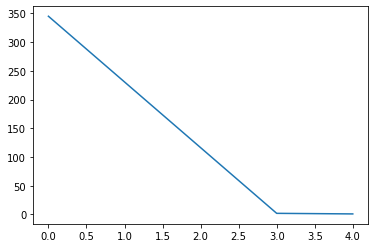

PPERSAUT
defaultdict(<class 'dict'>, {6: 262, 0: 72, 5: 14})


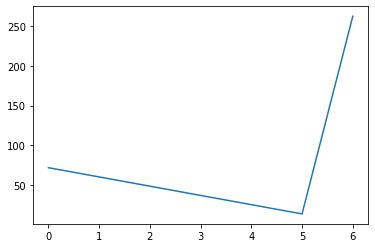

PBESAUT
defaultdict(<class 'dict'>, {0: 346, 6: 2})


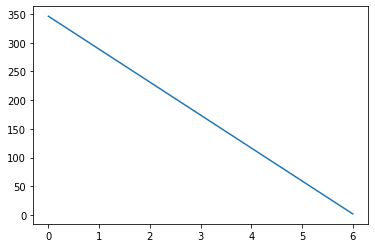

PMOTSCO
defaultdict(<class 'dict'>, {0: 332, 5: 4, 4: 9, 6: 1, 3: 2})


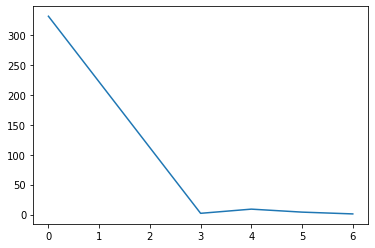

PVRAAUT
defaultdict(<class 'dict'>, {0: 348})


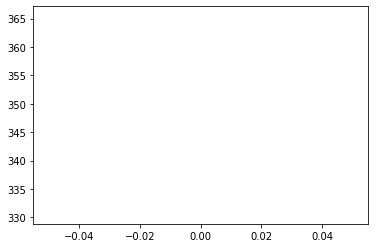

PAANHANG
defaultdict(<class 'dict'>, {0: 342, 2: 5, 1: 1})


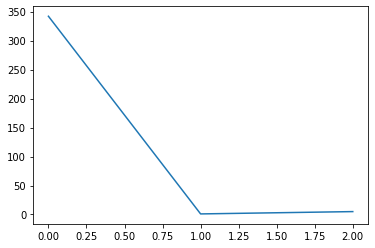

PTRACTOR
defaultdict(<class 'dict'>, {0: 343, 5: 2, 6: 1, 3: 2})


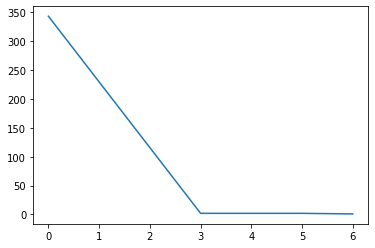

PWERKT
defaultdict(<class 'dict'>, {0: 348})


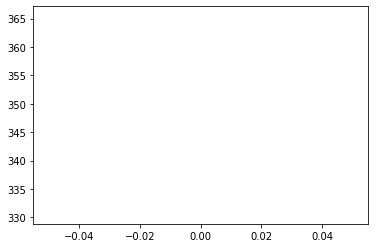

PBROM
defaultdict(<class 'dict'>, {0: 340, 3: 6, 2: 1, 5: 1})


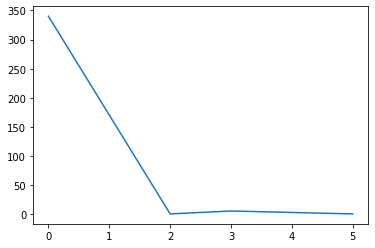

PLEVEN
defaultdict(<class 'dict'>, {0: 325, 5: 4, 3: 6, 4: 11, 6: 2})


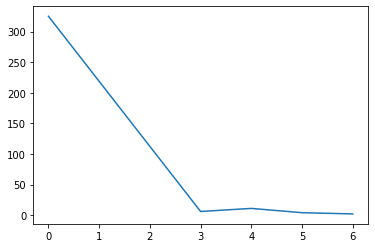

PPERSONG
defaultdict(<class 'dict'>, {0: 347, 2: 1})


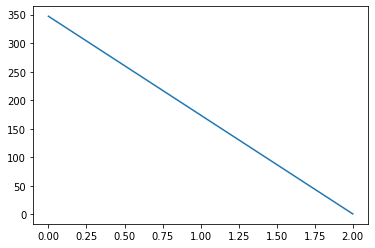

PGEZONG
defaultdict(<class 'dict'>, {0: 342, 3: 4, 2: 2})


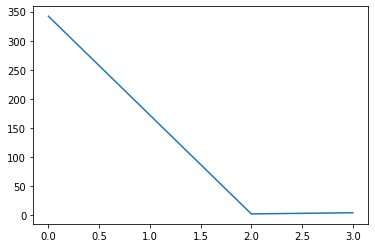

PWAOREG
defaultdict(<class 'dict'>, {0: 344, 6: 4})


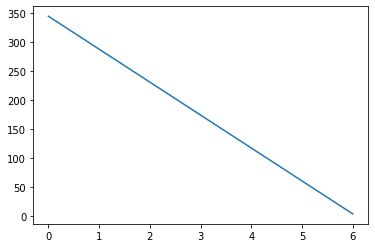

PBRAND
defaultdict(<class 'dict'>, {4: 151, 3: 68, 0: 109, 6: 3, 5: 8, 2: 6, 1: 3})


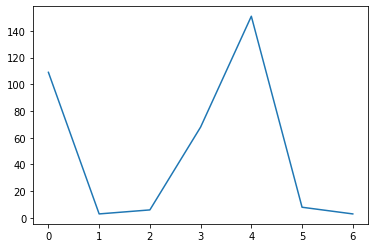

PZEILPL
defaultdict(<class 'dict'>, {0: 347, 1: 1})


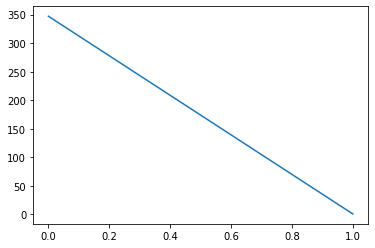

PPLEZIER
defaultdict(<class 'dict'>, {0: 335, 1: 3, 4: 4, 2: 2, 6: 2, 3: 2})


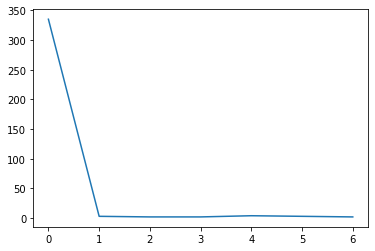

PFIETS
defaultdict(<class 'dict'>, {1: 15, 0: 333})


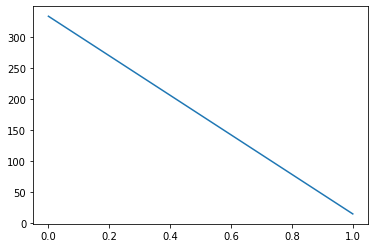

PINBOED
defaultdict(<class 'dict'>, {0: 343, 1: 3, 2: 2})


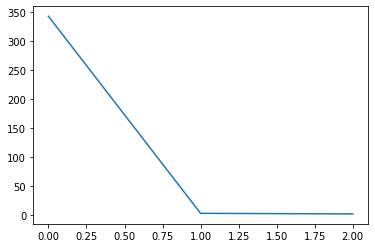

PBYSTAND
defaultdict(<class 'dict'>, {0: 332, 4: 8, 3: 4, 2: 4})


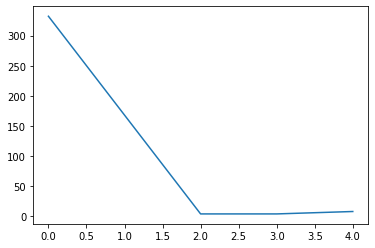

AWAPART
defaultdict(<class 'dict'>, {1: 201, 0: 147})


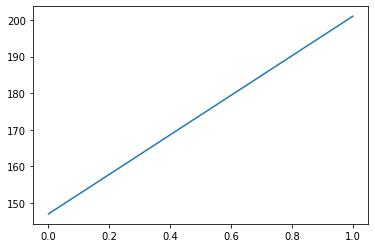

AWABEDR
defaultdict(<class 'dict'>, {0: 343, 1: 5})


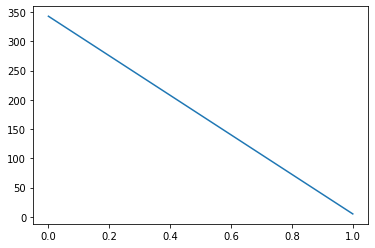

AWALAND
defaultdict(<class 'dict'>, {0: 345, 1: 3})


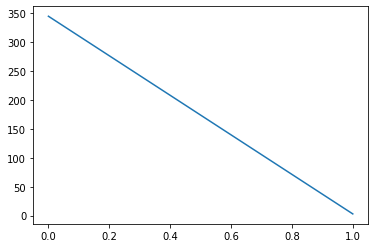

APERSAUT
defaultdict(<class 'dict'>, {1: 237, 0: 72, 2: 38, 3: 1})


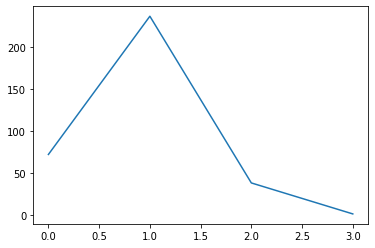

ABESAUT
defaultdict(<class 'dict'>, {0: 346, 1: 2})


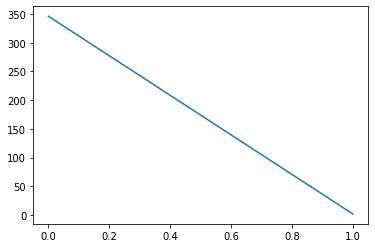

AMOTSCO
defaultdict(<class 'dict'>, {0: 332, 1: 15, 2: 1})


KeyboardInterrupt: 

In [5]:
labels = landsat_labels_original.iloc[:,0].tolist()
for i in range(0,85):
    print(labels[i])
    draw_relation(labels[i])
    plt.plot(x[i],y[i])
    plt.xlabel = labels[i]
    plt.ylabel = "policy"
    plt.show()
    #plt.savefig('./project/relation_fig/{}.png'.format(labels[i]))

In [ ]:
Counter(landsat_train_original["PWERKT"])
draw_relation("PWERKT")
plt.plot(0,348)

In [4]:
sample_num = landsat_train.shape[0]
feature_num = landsat_train.shape[1]-1
print("There are {} entries and {} columns in the landsat_train DataFrame"\
      .format(sample_num, feature_num))
if(landsat_train[landsat_train.isnull().values==True].empty):
    print('There is no missing data.')

There are 5822 entries and 73 columns in the landsat_train DataFrame
There is no missing data.


In [5]:
from scipy.stats import skew, kurtosis
print('Skewness:\n{}'.format(skew(landsat_train)[:-1])) # Get rid of label column 
print('Kurtosis:\n{}'.format(kurtosis(landsat_train)[:-1])) # Get rid of label column

Skewness:
[-0.43495833  7.4175204   0.18342661  0.47185398 -0.33144384  2.2375116
  0.07451129  0.90208138 -0.13127944 -0.71894299  1.31628589  0.69317304
  0.97007879  0.17975748  0.17708017  0.70351426  1.17377376  2.84527031
  2.82644798  0.65594135  0.67851784  0.66990708  0.56359308  0.15106264
 -0.15819589 -0.15846367 -0.68686506  0.67784008  0.81626251  0.22045397
  0.55312483 33.76619524  8.11726382  0.98972035 15.52025376 11.59361415
 62.67801573 35.82208342 18.98700265 41.56339353 15.87558049 26.19298932
 49.76902903 14.46574138 21.55057312  7.91871417 70.98940845 38.51073453
  6.05238344 64.91464756 10.78450371  1.22708466  0.42156412 14.33382469
  6.7481636   0.97711569 16.73079297 10.9484243  33.85295356 12.22044974
  9.45165509 29.45102564  3.73915787  6.70513793 13.59455055 12.25630842
 18.71467966  0.7502677  44.01894118 14.62299862  7.53869178 11.80511472
  8.49160361]
Kurtosis:
[-1.35210973e+00  1.00020762e+02  1.19646923e-02  6.20278204e-01
 -1.34489581e+00  8.620791

Feature Distribution

In [6]:
feature86_zero = sum(landsat_train["CARAVAN"]==0)
print('There are {} zeros in home policies feature, account for {:.2f}% of samples'.format(feature86_zero, 100*feature86_zero/5822))

There are 5474 zeros in home policies feature, account for 94.02% of samples


In [7]:
# #landsat_train["MOSTYPE"]
# landsat_train["MOSTYPE"][5821]

In [8]:
def transform(feature, class1, class2):
    new = []
    for ii in range(sample_num):
        if(new_data[feature][ii] in class1.values):
            new.append(0)
        elif(new_data[feature][ii] in class2.values):
            new.append(1)
        else:
            print('{} Error! {} is not in the list!'.format(ii,new_data[feature][ii]))
    return new
high_risk = Series([8, 9, 12, 13, 23, 25, 36, 2, 3, 4, 5, 15, 27])
low_risk = Series([1,6,7,10,11,14,16,17,18,19,20,21,22,24,26,28,29,30,31,32,33,34,35,37,38,39,40,41])
Liberals = Series([1, 2, 5, 6])
Conservatives = Series([3, 4, 7, 8, 9, 10])

new_data = landsat_train.copy()
new_data["MOSTYPE"] =  Series(transform("MOSTYPE", high_risk, low_risk))
new_data["MOSHOOFD"] = Series(transform("MOSHOOFD", Liberals, Conservatives))
X_train_full = new_data.iloc[:,:-1].copy()
y_train_full = new_data.iloc[:,-1].copy()

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
                                                  test_size=0.33, random_state=random_state)


In [9]:
# X_train_full = landsat_train_original.iloc[:,:-1].copy()
# y_train_full = landsat_train_original.iloc[:,-1].copy()
# print(X_train_full.shape)
# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, 
#                                                    test_size=0.33, random_state=random_state)

In [10]:
#需要标准化部分
norm_train = X_train.iloc[:, 30:52].copy()
norm_val = X_val.iloc[:, 30:52].copy()
print(norm_train.iloc[:, 0:30].shape)

(3900, 22)


Counter({150: 620,
         0: 1790,
         75: 345,
         350: 831,
         25: 111,
         3000: 92,
         750: 104,
         7500: 6,
         15000: 1})

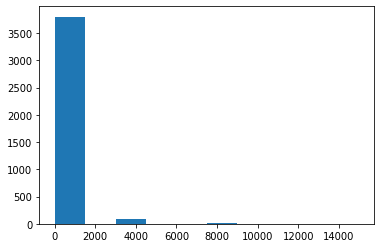

In [11]:
value = X_train.iloc[:,45].values
plt.hist(value)
plt.figure
Counter(value)

In [12]:
#normalize part data
from sklearn.preprocessing import StandardScaler
normal_train = norm_train.values
normal_val = norm_val.values
sc = StandardScaler().fit(normal_train)
norm_train_sc = sc.transform(normal_train)
norm_val_sc = sc.transform(normal_val)
X_train_sc = np.zeros((X_train.shape[0],X_train.shape[1]))
X_val_sc = np.zeros((X_val.shape[0],X_val.shape[1]))
X_train_sc[:,:30]= X_train.iloc[:,:30]
X_train_sc[:,30:52] = norm_train_sc
X_val_sc[:,:30]= X_val.iloc[:,:30]
X_val_sc[:,30:52] = norm_val_sc
X_train_sc
#print(sc.mean_)
#print(X_train_sc,'\n', y_train,'\n', X_val_sc,'\n', y_val)

array([[1., 2., 3., ..., 0., 0., 0.],
       [1., 1., 3., ..., 0., 0., 0.],
       [1., 1., 4., ..., 0., 0., 0.],
       ...,
       [0., 1., 3., ..., 0., 0., 0.],
       [0., 1., 3., ..., 0., 0., 0.],
       [1., 1., 3., ..., 0., 0., 0.]])

In [13]:
# #Normalizing all data
# sc_all = StandardScaler().fit(X_train)
# X_train_sc_all = sc_all.transform(X_train)
# X_val_sc_all = sc_all.transform(X_val)

In [14]:
# #centering all data
# from sklearn.preprocessing import MinMaxScaler
# min_max_scaler = MinMaxScaler()
# X_train_minmax = min_max_scaler.fit_transform(X_train)
# X_val_minmax =min_max_scaler.fit_transform(X_val)
# np.savetxt('all.csv',X_train_minmax,delimiter=',')

In [15]:
# #centering part data
# X_train_minmaxall = min_max_scaler.fit_transform(normal_train)
# X_val_minmaxall =min_max_scaler.fit_transform(normal_val)
# X_train_m = np.zeros((X_train.shape[0],X_train.shape[1]))
# X_val_m = np.zeros((X_val.shape[0],X_val.shape[1]))
# X_train_m[:,:30]= X_train.iloc[:,:30]
# X_train_m[:,30:52] = X_train_minmaxall
# X_val_m[:,:30]= X_val.iloc[:,:30]
# X_val_m[:,30:52] = X_val_minmaxall
# np.savetxt('part.csv',X_train_m,delimiter=',')

In [16]:
X_train_final = X_train_sc
X_val_final = X_val_sc


In [17]:
# np.savetxt('train.csv',X_train_final,delimiter=',')

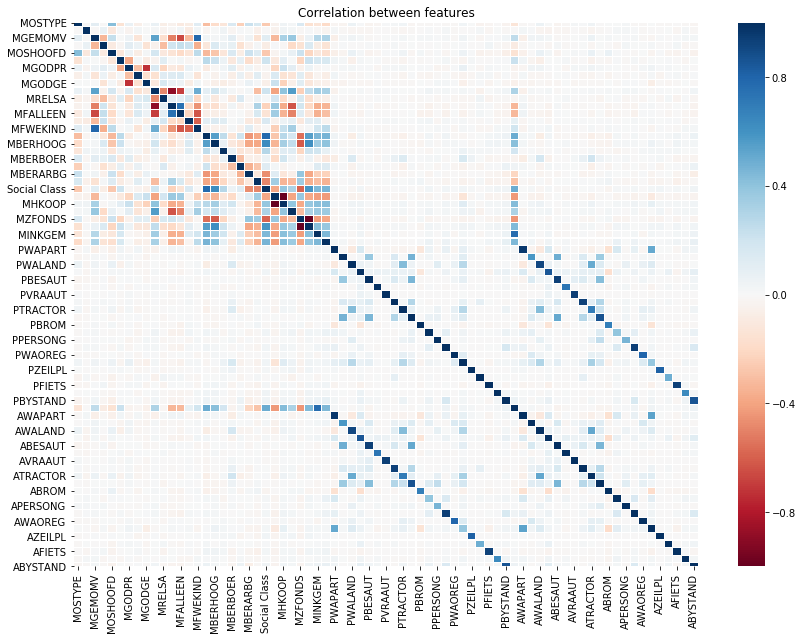

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

data = X_train.corr()  #test_feature => pandas.DataFrame#

f, ax= plt.subplots(figsize = (14, 10))
sns.heatmap(data,cmap='RdBu', linewidths = 0.05, ax = ax)

ax.set_title('Correlation between features')
plt.show()

f.savefig('corr.png', dpi=540, bbox_inches='tight')

In [19]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X_train_final,y_train)

In [20]:
from sklearn.metrics import accuracy_score
# By using the predict() method and accuracy_score metric
gnb_prediction = gnb.predict(X_val_final)
gnb_accuracy = accuracy_score(y_val, gnb_prediction) # The accuracy_score() function takes as inputs
                                                 # the true labels and the predicted ones

# By using the score() method
gnb_accuracy_alt = gnb.score(X_val_final, y_val) # The score() method takes as inputs 
                                              # the test input features and the associated (true) labels

# Print results
print("GNB classification accuracy on validation set (by using the accuracy_score() function): {:.3f}"
      .format(gnb_accuracy))
print("GNB classification accuracy on validation set (by using the model's score() method): {:.3f}"
      .format(gnb_accuracy_alt))

GNB classification accuracy on validation set (by using the accuracy_score() function): 0.107
GNB classification accuracy on validation set (by using the model's score() method): 0.107


In [21]:
from sklearn.dummy import DummyClassifier
# Your code goes here

# most_frequent strategy
dcl_mf = DummyClassifier(strategy='most_frequent')
dcl_mf.fit(X_train_final, y_train) # Clf user guide for alternative strategy options
y_most_frequent = dcl_mf.predict(X_val_final)

# uniformly random prediction strategy
# Set random_state parameter to ensure reproducibility
dcl_rnd = DummyClassifier(strategy='uniform', random_state=10).fit(X_train_final, y_train) 
y_random = dcl_rnd.predict(X_val_final)

print("Baseline classification accuracy on validation set (most frequent class): {:.3f}".
      format(accuracy_score(y_val, y_most_frequent)))
print("Baseline classification accuracy on validation set (random prediction): {:.3f}".
      format(accuracy_score(y_val, y_random)))

Baseline classification accuracy on validation set (most frequent class): 0.939
Baseline classification accuracy on validation set (random prediction): 0.517


Confusion matrix
[[  91 1714]
 [   3  114]]


TypeError: 'str' object is not callable

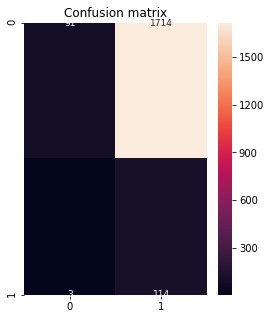

In [25]:
from sklearn.metrics import confusion_matrix
# Your code goes here
cm = confusion_matrix(y_val, gnb_prediction)
print('Confusion matrix\n{}'.format(cm))
def plot_confusion_matrix(cm, normalize=False, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix.
    
    If normalize is set to True, the rows of the confusion matrix are normalized so that they sum up to 1.
    
    """
    if normalize is True:
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        vmin, vmax = 0., 1.
        fmt = '.2f'
    else:
        vmin, vmax = None, None
        fmt = 'd'
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=vmin, vmax=vmax, 
                    annot=True, annot_kws={"fontsize":9}, fmt=fmt)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
fig = plt.figure(figsize=(9,5))
ax1 = fig.add_subplot(121)
plot_confusion_matrix(cm, normalize=False, \
                      classes=gnb.classes_) # un-normalized
ax2 = fig.add_subplot(122)
plot_confusion_matrix(cm, normalize=True, \
                      classes=gnb.classes_, title='Normalised confusion matrix') # normalized
ax2.get_yaxis().set_visible(False)
fig.tight_layout()
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import log_loss,recall_score
# Your code goes here
starttime = time.time()
pred_proba_dummy = dcl_mf.predict_proba(X_val_final)
pred_proba_gnb = gnb.predict_proba(X_val_final)
print("Log-loss scores:\nDummy classifier {}\nGaussian Naive Bayes classifier {}".
      format(log_loss(y_val, pred_proba_dummy), log_loss(y_val, pred_proba_gnb)))
names = ["Logistic Regression", "Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net (Multi-layer perceptron)",
         "Naive Bayes", "LDA", "QDA"]
#names = ["Logistic Regression"]
classifiers = [
    LogisticRegression(max_iter = 1000),
    KNeighborsClassifier(n_neighbors=9),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=50,random_state=random_state),
    MLPClassifier(random_state=random_state,max_iter=300),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
ca_score = {} # Classification accuracy
ce_score = {} # Cross-entropy
pre = {}
for name, clf in zip(names, classifiers):
    clf.fit(X_train_final, y_train)
    pre[name] = clf.predict(X_val_final)
    ca_score[name] = clf.score(X_val_final, y_val)
    ce_score[name] = log_loss(y_val, clf.predict_proba(X_val_final))
print('Classification performance on validation set:')

df = pd.DataFrame()
for clf in names:
    rc = recall_score(y_val, pre[clf], average='micro')
    print(clf,'recall:',rc)
    df[clf] = ca_score[clf]

# print(df.to_latex(index=False)) 
endtime = time.time()
dtime = endtime - starttime


Log-loss scores:
Dummy classifier 2.102516565142847
Gaussian Naive Bayes classifier 27.98025678630099
Classification performance on validation set:
Logistic Regression recall: 0.9375650364203955
Nearest Neighbors recall: 0.9380853277835588
Linear SVM recall: 0.9391259105098856
RBF SVM recall: 0.9391259105098856
Decision Tree recall: 0.9193548387096774
Random Forest recall: 0.9375650364203955
Neural Net (Multi-layer perceptron) recall: 0.9349635796045785
Naive Bayes recall: 0.10665972944849116
LDA recall: 0.9339229968782519
QDA recall: 0.14932362122788762


C:\Users\Lynn\Miniconda3\envs\dme\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
df

优化部分

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
svc = SVC(kernel='rbf')
parameters = {'C': np.logspace(-3,3,7)}
svc_clf = GridSearchCV(estimator=svc, cv=cv, param_grid=parameters, scoring='accuracy')
svc_clf.fit(X_train_final, y_train)
print("Best setting of C parameter for SVC with RBF kernel: {}".format(svc_clf.best_params_["C"]))
print("Best cross-validated score: {:.3f}".
      format(svc_clf.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(svc_clf.score(X_val_final,y_val)))

Best setting of C parameter for SVC with RBF kernel: 0.001
Best cross-validated score: 0.941
Classification accuracy on validation set: 0.939


In [127]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
svc = SVC(kernel='rbf')
parameters = {'C': np.logspace(-3,3,7), 'gamma' : np.logspace(-4, 1, 6)}
svc_clf = GridSearchCV(estimator=svc, cv=cv, param_grid=parameters, scoring='accuracy')
svc_clf.fit(X_train_final, y_train)
print("Best parameters for SVC with RBF kernel, C: {}, gamma: {}".
      format(svc_clf.best_params_["C"], svc_clf.best_params_["gamma"]))
print("Best cross-validated score: {}".
      format(svc_clf.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(svc_clf.score(X_val_final,y_val)))

Best parameters for SVC with RBF kernel, C: 0.001, gamma: 0.0001
Best cross-validated score: 0.9407692307692308
Classification accuracy on validation set: 0.939


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

# MLP with variable hidden layer size and alpha, score: log-loss
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
mlp = MLPClassifier(random_state=random_state)
parameters = {'hidden_layer_sizes' : [(10,), (100,), (1000,)], 'alpha' : np.logspace(-8,0,9)}
mlp_clf = GridSearchCV(mlp, param_grid=parameters, scoring='neg_log_loss')
mlp_clf.fit(X_train_final, y_train)
print("Best parameters for MLP classifier: hidden layer size: {}, alpha: {}, best cross-validated score: {:.3f}".
      format(mlp_clf.best_params_["hidden_layer_sizes"], mlp_clf.best_params_["alpha"], mlp_clf.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(accuracy_score(y_val, mlp_clf.predict(X_val_final))))

In [ ]:
# MLP with variable hidden layer size and alpha, score: accuracy
cv = KFold(n_splits=3, shuffle=True, random_state=random_state)
mlp = MLPClassifier(random_state=random_state)
parameters = {'hidden_layer_sizes' : [(10,), (100,), (1000,)], 'alpha' : np.logspace(-8,0,9)}
mlp_clf = GridSearchCV(mlp, param_grid=parameters, scoring='accuracy')
mlp_clf.fit(X_train_final, y_train)
print("Best parameters for MLP classifier: hidden layer size: {}, alpha: {}, best cross-validated score: {:.3f}".
      format(mlp_clf.best_params_["hidden_layer_sizes"], mlp_clf.best_params_["alpha"], mlp_clf.best_score_))
print("Classification accuracy on validation set: {:.3f}".format(accuracy_score(y_val, mlp_clf.predict(X_val_sc))))

In [ ]:
from sklearn.model_selection import cross_val_score
cv = KFold(n_splits=3, shuffle=True, random_state=random_state) # We want to use 3-fold CV to compute the loss in each iteration
svc_clf = SVC(kernel='rbf') # Constructor without defining hyper-parameters just yet

def objective_svc(params): # Here we define the metric we want to minimise
    C, gamma = params
    svc_clf.set_params(C=C, 
                      gamma=gamma) # Set the parameters of the clf
    
    return -np.mean(cross_val_score(svc_clf, X_train_final, y_train, cv=cv, n_jobs=-1,
                                    scoring="accuracy")) # We want to maximise average accuracy, i.e. minimise minus average accuracy

# Search space for the two parameters
space  = [(10**-3, 10**3, "uniform"), # C
          (10**-4, 10**1, "uniform")] # gamma

# Initial values (optional)
x0 = [1, 10**-2]

In [ ]:
from skopt import gp_minimize
res_gp = gp_minimize(func=objective_svc, dimensions=space, x0=x0, 
                     n_calls=25, random_state=random_state, n_random_starts=5, kappa=1.9)
print("Best score with Bayesian optimisation: {:.3f}".format(-res_gp.fun))
print("Best parameters with Bayesian optimisation:\nC: {}\ngamma: {}"
      .format(res_gp.x[0],res_gp.x[1]))

In [ ]:
from skopt.plots import plot_convergence
plt.figure(figsize=(5,2))
plot_convergence(res_gp)
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(5,2))
plt.plot(res_gp.func_vals)
plt.scatter(range(len(res_gp.func_vals)), res_gp.func_vals)
plt.ylabel(r'$f(x)$')
plt.xlabel('Number of calls $n$')
plt.xlim([0, len(res_gp.func_vals)])
plt.show()

In [ ]:
svc_opt = SVC(kernel='rbf',
             C=res_gp.x[0],
             gamma=res_gp.x[1]).fit(X_train_sc,y_train)
print("Classification accuracy on validation set: {:.3f}".format(accuracy_score(y_val, svc_opt.predict(X_val_sc))))
print("Classification accuracy on test set: {:.3f}".format(accuracy_score(y_test, svc_opt.predict(X_test_sc))))

Not in use

In [246]:
def get_key (dict, value):
    return [k for k, v in dict.items() if v == value]

In [92]:
def newfeature(features):
    MG_prob = []
    MG_value = []
    for sample in range(sample_num):
        MG_dic = defaultdict(dict)
        for feature in features:
            MG_dic[feature] = landsat_train[feature][sample]
        pro = max(MG_dic.values())
        if(len(get_key(MG_dic, pro))==1):
            MG_NEW = get_key(MG_dic, pro)[0]
        elif(len(get_key(MG_dic, pro))==2):
            n = random.random()
            MG_NEW = get_key(MG_dic, pro)[0]
            if(n>=0.5):
                MG_NEW = get_key(MG_dic, pro)[1]
        elif(len(get_key(MG_dic, pro))==3):
            n = random.uniform(0,3)
            MG_NEW = get_key(MG_dic, pro)[0]
            if(n>=1):
                MG_NEW = get_key(MG_dic, pro)[1]
            elif(n>=2):
                MG_NEW = get_key(MG_dic, pro)[2]
        elif(len(get_key(MG_dic, pro))==4):
            n = random.uniform(0,4)
            MG_NEW = get_key(MG_dic, pro)[0]
            if(n>=1):
                MG_NEW = get_key(MG_dic, pro)[1]
            elif(n>=2):
                MG_NEW = get_key(MG_dic, pro)[2]
            elif(n>=3):
                MG_NEW = get_key(MG_dic, pro)[3]
        elif(len(get_key(MG_dic, pro))==5):
            n = random.uniform(0,5)
            MG_NEW = get_key(MG_dic, pro)[0]
            if(n>=1):
                MG_NEW = get_key(MG_dic, pro)[1]
            elif(n>=2):
                MG_NEW = get_key(MG_dic, pro)[2]
            elif(n>=3):
                MG_NEW = get_key(MG_dic, pro)[3]
            elif(n>=4):
                MG_NEW = get_key(MG_dic, pro)[4]
        for feature in range(len(features)):
            if (MG_NEW == features[feature]):
                MG_value.append(feature)
        MG_prob.append(pro)
    return MG_NEW,MG_value
#newfeature(["MBERHOOG","MBERZELF","MBERBOER","MBERMIDD","MBERARBG","MBERARBO"])

In [88]:
labels_path = os.path.join(os.getcwd(), 'project', 'dataset', 'L0_Labels.csv')
L0_Labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
labels_path = os.path.join(os.getcwd(), 'project', 'dataset', 'L1_Labels.csv')
L1_Labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
labels_path = os.path.join(os.getcwd(), 'project', 'dataset', 'L2_Labels.csv')
L2_Labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
labels_path = os.path.join(os.getcwd(), 'project', 'dataset', 'L3_Labels.csv')
L3_Labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
labels_path = os.path.join(os.getcwd(), 'project', 'dataset', 'L4_Labels.csv')
L4_Labels = pd.read_csv(labels_path, delimiter = ',', index_col=0)
L2_Labels

,L2_Labels
1,Successful hedonists
2,Driven Growers
3,Average Family
4,Career Loners
5,Living well
6,Cruising Seniors
7,Retired and Religeous
8,Family with grown ups
9,Conservative families
10,Farmers


In [48]:
L0_labels_dict = L0_Labels.to_dict()["L0_Labels"]
L1_labels_dict = L1_Labels.to_dict()["L1_Labels"]
L2_labels_dict = L2_Labels.to_dict()["L2_Labels"]
L3_labels_dict = L3_Labels.to_dict()["L3_Labels"]
L4_labels_dict = L4_Labels.to_dict()["L4_Labels"]

In [19]:
def draw_relation(feature):
#     fig, ax = plt.subplots(30,1, figsize=(17,4))
    c =Counter(landsat_train[feature])
    sorted_c =np.array(sorted(c.items(),key=lambda x:x[0])) 
    x.append(sorted_c[:,0])
    y.append(sorted_c[:,1])
    print(feature)


MOSTYPE


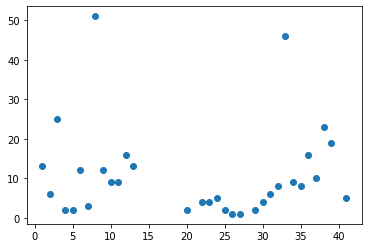

MAANTHUI


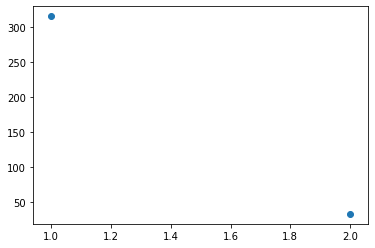

MGEMOMV


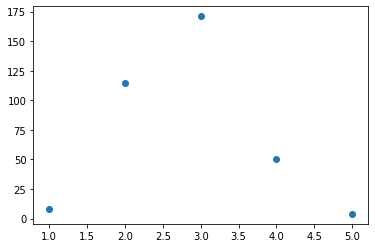

MGEMLEEF


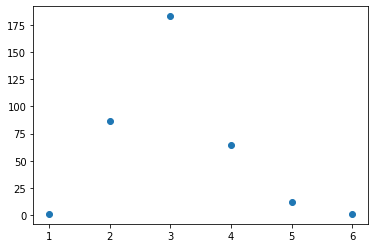

MOSHOOFD


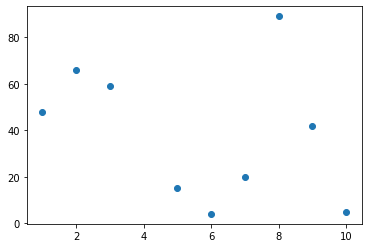

MGODRK


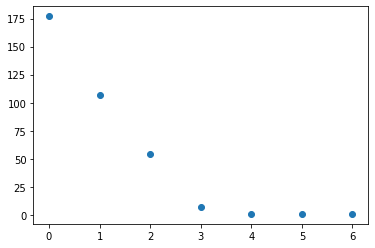

MGODPR


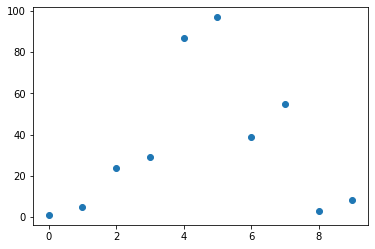

MGODOV


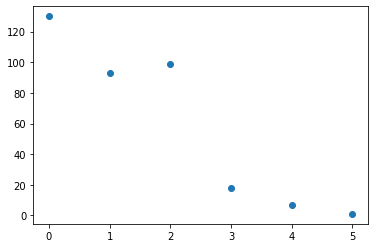

MGODGE


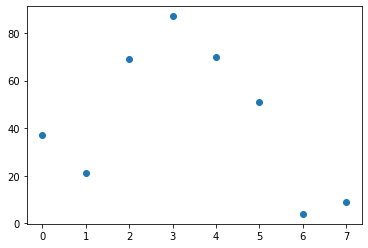

MRELGE


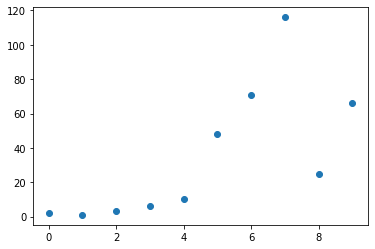

MRELSA


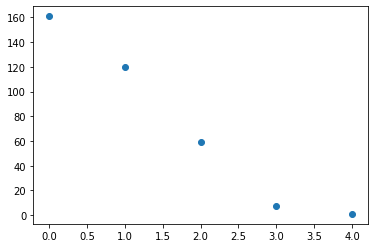

MRELOV


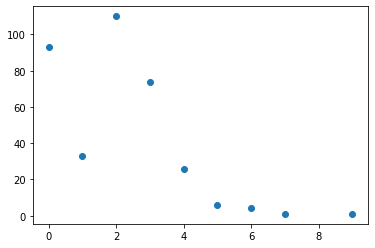

MFALLEEN


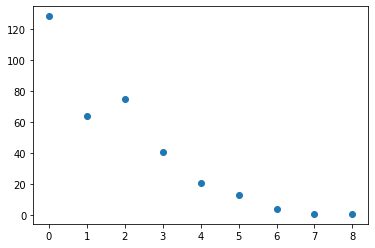

MFGEKIND


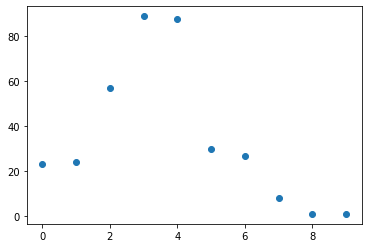

MFWEKIND


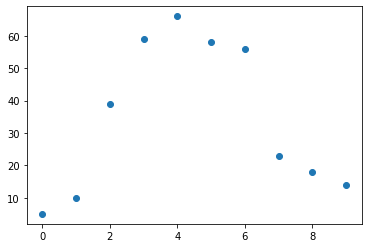

Education Level(high-3,medium-2,low-1)


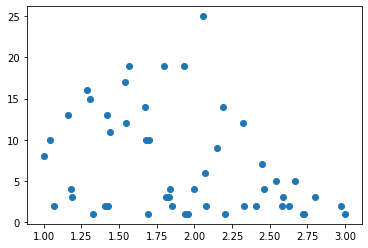

MBERHOOG


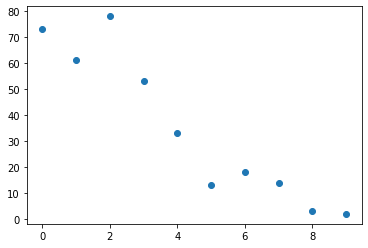

MBERZELF


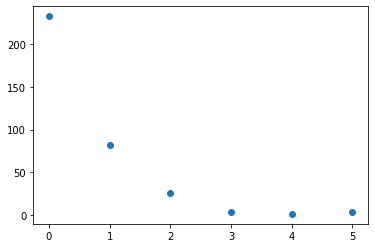

MBERBOER


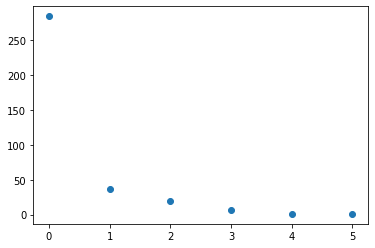

MBERMIDD


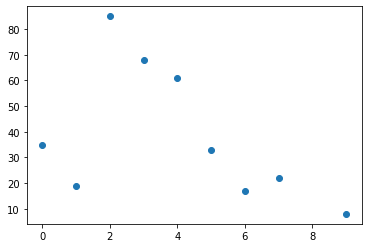

MBERARBG


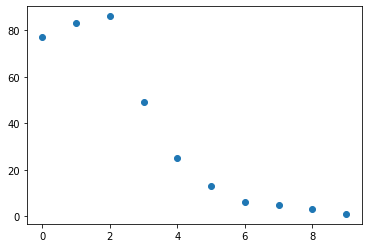

MBERARBO


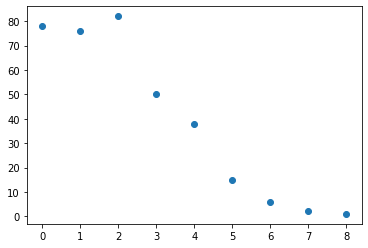

Social Class


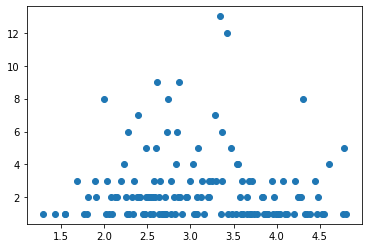

MHHUUR


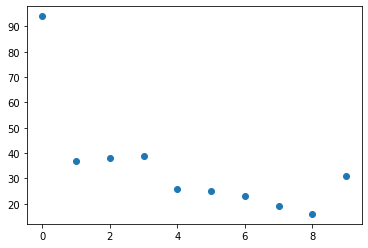

MHKOOP


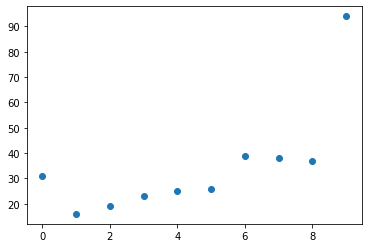

Number of car


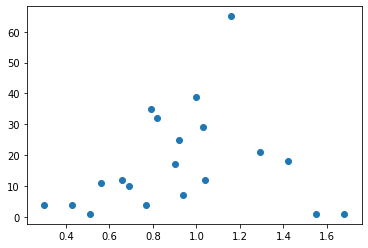

MZFONDS


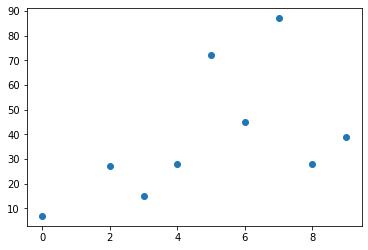

MZPART


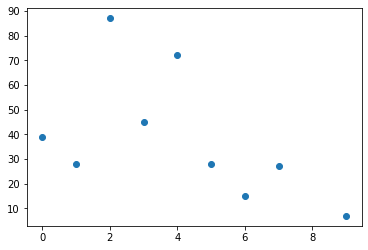

MINKGEM


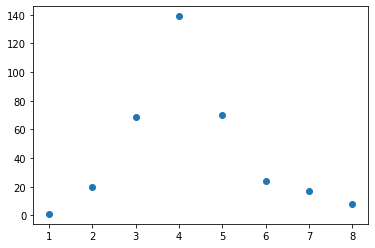

MKOOPKLA


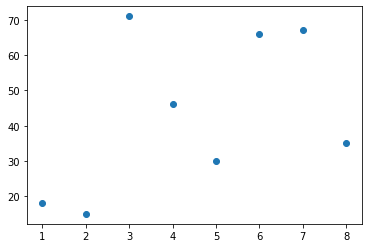

PWAPART


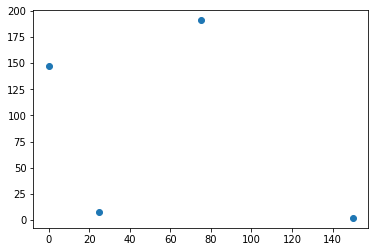

PWABEDR


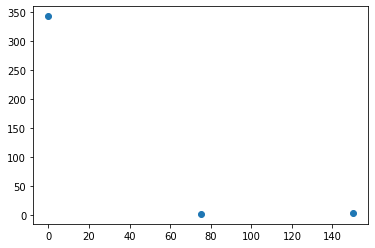

PWALAND


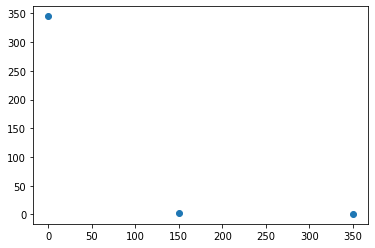

PPERSAUT


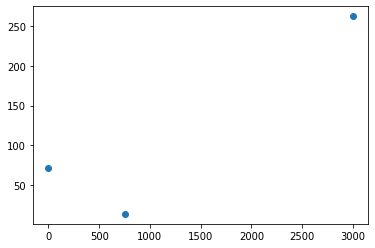

PBESAUT


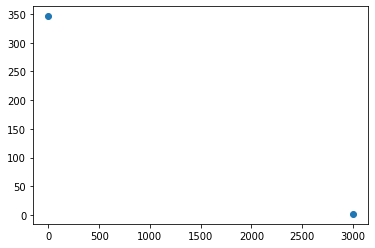

PMOTSCO


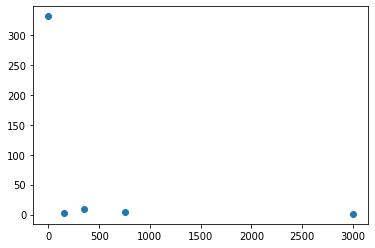

PVRAAUT


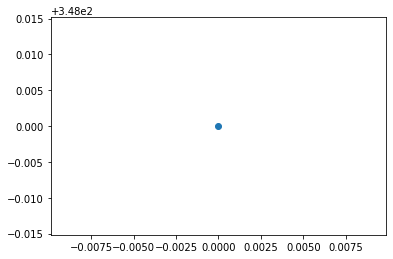

PAANHANG


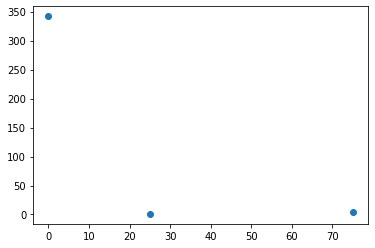

PTRACTOR


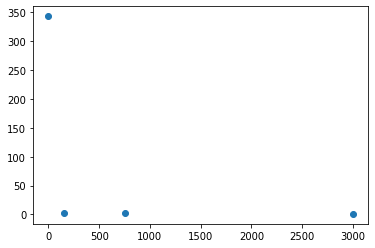

PWERKT


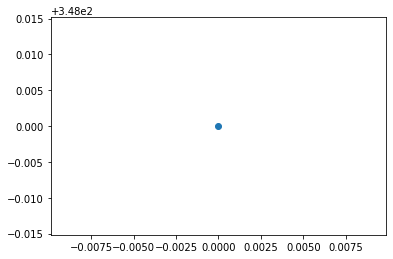

PBROM


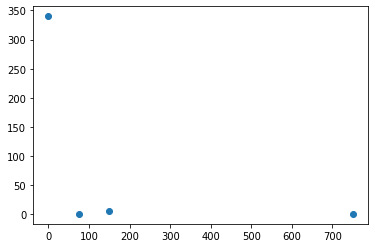

PLEVEN


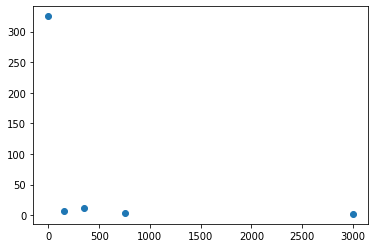

PPERSONG


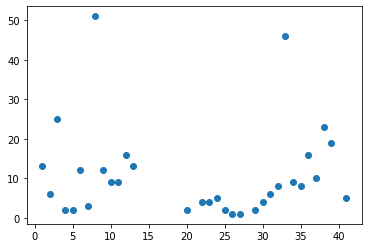

PGEZONG


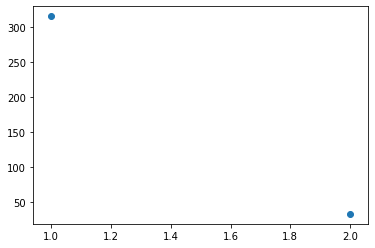

PWAOREG


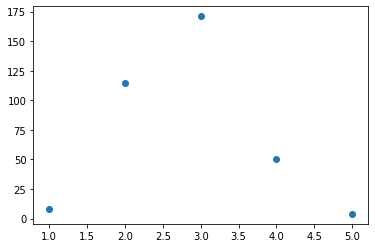

PBRAND


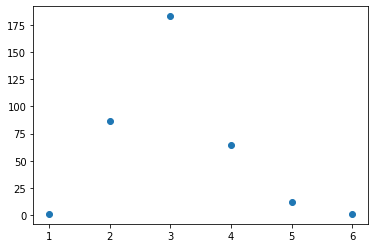

PZEILPL


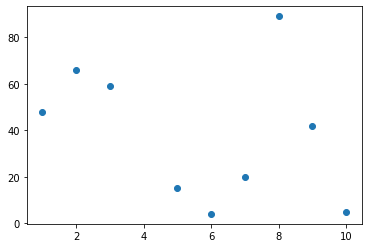

PPLEZIER


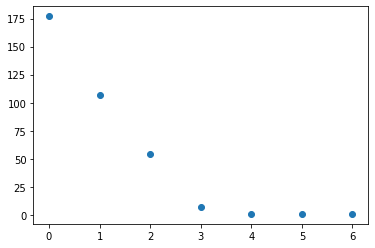

PFIETS


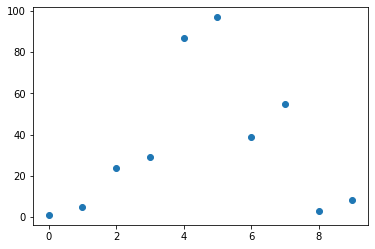

PINBOED


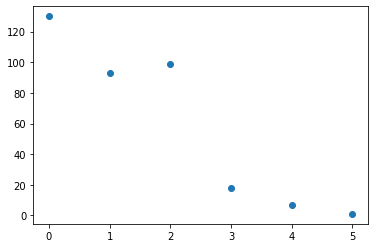

PBYSTAND


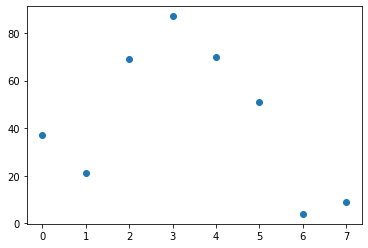

Expexted Income


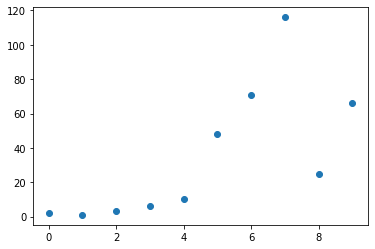

AWAPART


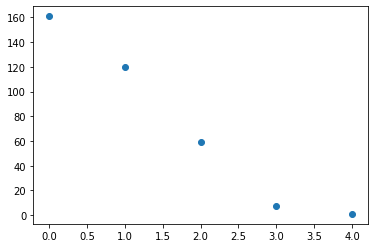

AWABEDR


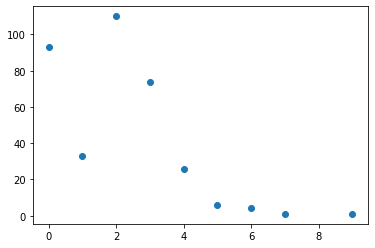

AWALAND


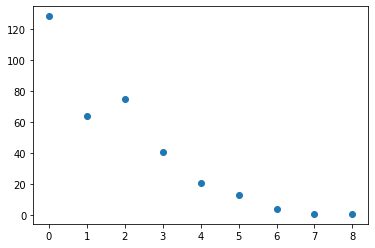

APERSAUT


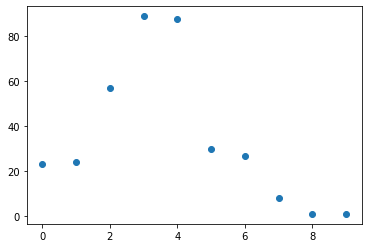

ABESAUT


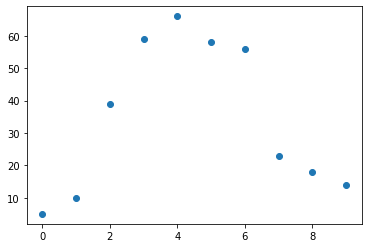

AMOTSCO


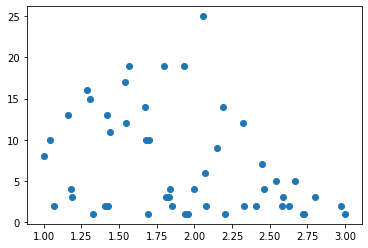

AVRAAUT


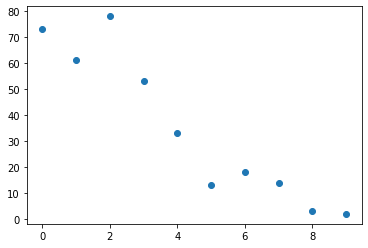

AAANHANG


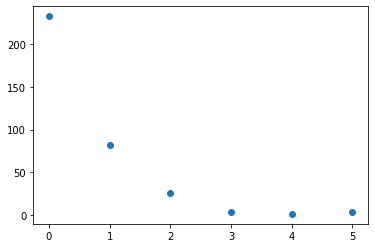

ATRACTOR


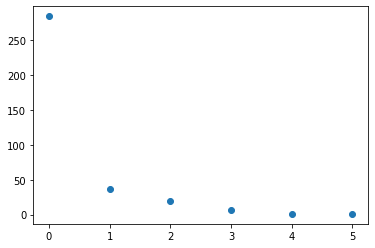

AWERKT


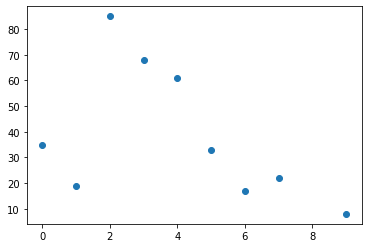

ABROM


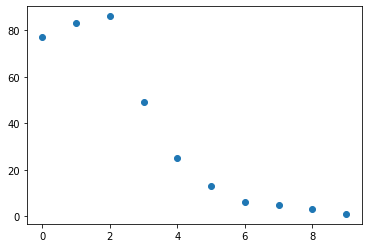

ALEVEN


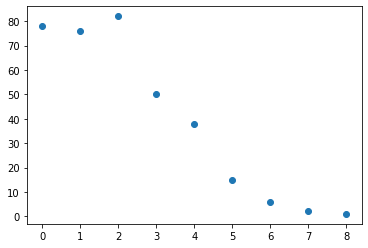

APERSONG


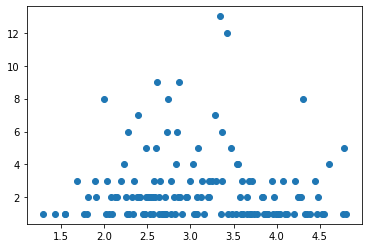

AGEZONG


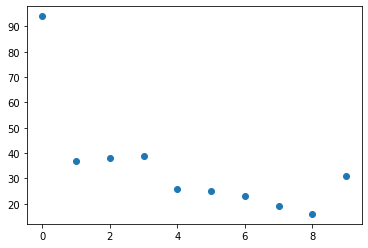

AWAOREG


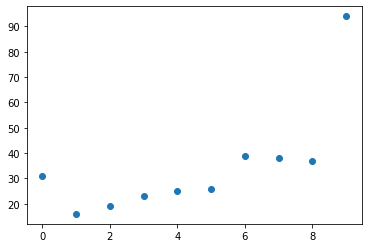

ABRAND


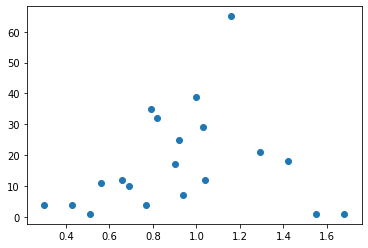

AZEILPL


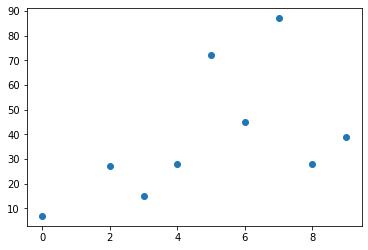

APLEZIER


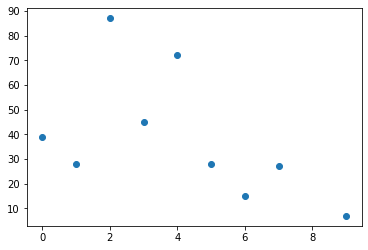

AFIETS


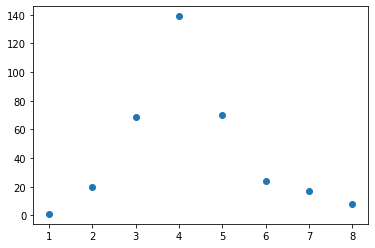

AINBOED


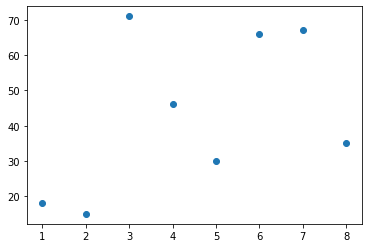

ABYSTAND


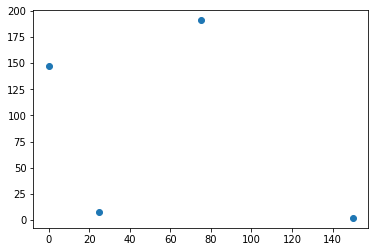

In [65]:
Counter(landsat_train["PWERKT"])

Counter({0: 5801, 75: 4, 3000: 3, 350: 8, 150: 6})

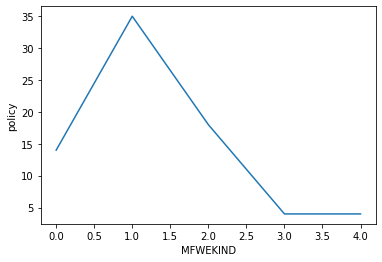

In [199]:
dic = defaultdict(dict)
age = []
policy = []
buyer = []

for ii in range(sample_num):
    if (landsat_train["MRELGE"][ii] == 1):
        buyer.append(ii)
        if (dic.get(landsat_train[feature][ii])):
            dic[landsat_train[feature][ii]] += 1 
        else :
            dic[landsat_train[feature][ii]] = 1

for i in sorted (dic) : 
    age.append(i)
    policy.append(dic[i])
plt.xlabel(str(feature))
plt.ylabel("policy")
plt.plot(age, policy)
plt.savefig('./{}.png'.format(str(feature)))

In [34]:
landsat_train["APLEZIER"][1]

0

In [94]:
Counter(landsat_train["MINKGEM"])

Counter({4: 1854,
         5: 733,
         3: 1932,
         6: 355,
         2: 651,
         8: 70,
         1: 49,
         7: 131,
         9: 22,
         0: 25})